In [68]:
from  fiona import listlayers

ecuadorMapsLink='https://github.com/SeaWaterProject/ECUADOR/raw/main/maps/ecuadorMaps_24817.gpkg'

#layers in maps
listlayers(ecuadorMapsLink)

['country', 'cities', 'rivers', 'centroid', 'airports']

In [69]:
import geopandas as gpd

airports=gpd.read_file(ecuadorMapsLink,layer='airports')
rivers=gpd.read_file(ecuadorMapsLink,layer='rivers')
cities=gpd.read_file(ecuadorMapsLink,layer='cities')

In [70]:
import pandas as pd 

portsFileLink="https://github.com/CienciaDeDatosEspacial/GeoDataFrame_Analytics/raw/main/data/UpdatedPub150.csv"
infoseaports=pd.read_csv(portsFileLink)

#columns available (so many)
infoseaports.columns.to_list()

['World Port Index Number',
 'Region Name',
 'Main Port Name',
 'Alternate Port Name',
 'UN/LOCODE',
 'Country Code',
 'World Water Body',
 'IHO S-130 Sea Area',
 'Sailing Direction or Publication',
 'Publication Link',
 'Standard Nautical Chart',
 'IHO S-57 Electronic Navigational Chart',
 'IHO S-101 Electronic Navigational Chart',
 'Digital Nautical Chart',
 'Tidal Range (m)',
 'Entrance Width (m)',
 'Channel Depth (m)',
 'Anchorage Depth (m)',
 'Cargo Pier Depth (m)',
 'Oil Terminal Depth (m)',
 'Liquified Natural Gas Terminal Depth (m)',
 'Maximum Vessel Length (m)',
 'Maximum Vessel Beam (m)',
 'Maximum Vessel Draft (m)',
 'Offshore Maximum Vessel Length (m)',
 'Offshore Maximum Vessel Beam (m)',
 'Offshore Maximum Vessel Draft (m)',
 'Harbor Size',
 'Harbor Type',
 'Harbor Use',
 'Shelter Afforded',
 'Entrance Restriction - Tide',
 'Entrance Restriction - Heavy Swell',
 'Entrance Restriction - Ice',
 'Entrance Restriction - Other',
 'Overhead Limits',
 'Underkeel Clearance Manage

In [71]:
#EXERCISE 1

#rename
infoseaports.rename(columns={'Main Port Name':'portName'},inplace=True)
#keep few columns
infoseaports=infoseaports.loc[:,['portName', 'Country Code','Latitude', 'Longitude']]

# we have now
infoseaports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3739 entries, 0 to 3738
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   portName      3739 non-null   object 
 1   Country Code  3739 non-null   object 
 2   Latitude      3739 non-null   float64
 3   Longitude     3739 non-null   float64
dtypes: float64(2), object(2)
memory usage: 117.0+ KB


In [72]:
# some rows
infoseaports.head()

,portName,Country Code,Latitude,Longitude
0,Maurer,United States,40.533333,-74.250000
1,Mangkasa Oil Terminal,Indonesia,-2.733333,121.066667
2,Iharana,Madagascar,-13.350000,50.000000
3,Andoany,Madagascar,-13.400000,48.300000
4,Chake Chake,Tanzania,-5.250000,39.766667


In [73]:
#spatial points (unprojected)
seaports=gpd.GeoDataFrame(data=infoseaports.copy(),
                           geometry=gpd.points_from_xy(infoseaports.Longitude,
                                                       infoseaports.Latitude), 
                          crs=4326)# notice it is unprojected

# keep Brazil
seaports_ec=seaports[seaports['Country Code']=='Ecuador'].copy()

# reset indexes
seaports_ec.reset_index(drop=True, inplace=True)

# reprojecting
seaports_ec_24817=seaports_ec.to_crs(24817) # projected crs

<Axes: >

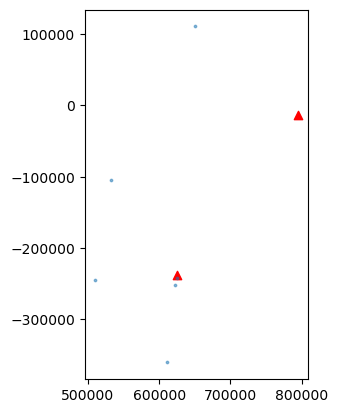

In [74]:
# subsetting
largeAirports=airports[airports['kind']=='large_airport'] #can't use "airports.type"
largeAirports.reset_index(drop=True, inplace=True)

#plotting
base=largeAirports.plot(color='red',marker="^")
seaports_ec_24817.plot(ax=base,alpha=0.5,markersize=3)

In [76]:
seaports_ec_24817.head()

,portName,Country Code,Latitude,Longitude,geometry
0,La Libertad,Ecuador,-2.216667,-80.916667,POINT (509516.830 -244646.236)
1,Esmeraldas,Ecuador,1.000000,-79.650000,POINT (650460.413 110925.830)
2,Manta,Ecuador,-0.950000,-80.716667,POINT (531773.463 -104641.236)
3,Guayaquil,Ecuador,-2.200000,-79.883333,POINT (624424.825 -242849.371)
4,Puerto Bolivar,Ecuador,-3.266667,-80.000000,POINT (611352.640 -360759.766)


In [77]:
largeAirports.head()

,name,kind,latitude_deg,longitude_deg,elevation_ft,region_name,municipality,geometry
0,Mariscal Sucre International Airport,large_airport,-0.125399,-78.354306,7841.0,Pichincha Province,Quito,POINT (794753.382 -13509.335)
1,José Joaquín de Olmedo International Airport,large_airport,-2.157420,-79.883598,19.0,Guayas Province,Guayaquil,POINT (624398.806 -238142.013)


In [78]:
# distance between 'Guarulhos' and 'Dtse / Gegua Oil Terminal' 
largeAirports.iloc[0].geometry.distance(seaports_ec_24817.iloc[0].geometry)/1000  # in km

367.12961970461566

In [79]:
#try 1: default
seaports_ec_24817.geometry.apply\
(lambda g: largeAirports.geometry.distance(g)/1000)

,0,1
0,367.129620,115.065953
1,190.537584,350.039378
2,278.322584,162.486651
3,285.672311,4.707430
4,392.706881,123.309837
5,294.203657,14.039011


In [80]:
# try 2: see names (change indexes)

seaports_ec_24817.set_index('portName').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000)

name,Mariscal Sucre International Airport,José Joaquín de Olmedo International Airport
portName,,
La Libertad,367.129620,115.065953
Esmeraldas,190.537584,350.039378
Manta,278.322584,162.486651
Guayaquil,285.672311,4.707430
Puerto Bolivar,392.706881,123.309837
Puerto Maritimo De Guayaquil,294.203657,14.039011


In [81]:
#try 3: reorder previous output

seaports_ec_24817.set_index('portName').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

name,José Joaquín de Olmedo International Airport,Mariscal Sucre International Airport
portName,,
Esmeraldas,350.039378,190.537584
Guayaquil,4.707430,285.672311
La Libertad,115.065953,367.129620
Manta,162.486651,278.322584
Puerto Bolivar,123.309837,392.706881
Puerto Maritimo De Guayaquil,14.039011,294.203657


In [83]:
distanceMatrixKM_sea_air= seaports_ec_24817.set_index('portName').geometry.apply\
                          (lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
                          sort_index(axis=0).sort_index(axis=1)

In [84]:
# the mean distance from a seaport to all the large airports (sorted)
distanceMatrixKM_sea_air.mean(axis=1).sort_values(ascending=True) #axis=0?

portName
Guayaquil                       145.189871
Puerto Maritimo De Guayaquil    154.121334
Manta                           220.404617
La Libertad                     241.097786
Puerto Bolivar                  258.008359
Esmeraldas                      270.288481
dtype: float64

In [85]:
SomeStats=pd.DataFrame()
SomeStats['mean']=distanceMatrixKM_sea_air.mean(axis=1)
SomeStats['min']=distanceMatrixKM_sea_air.min(axis=1)
SomeStats['max']=distanceMatrixKM_sea_air.max(axis=1)

# see some
SomeStats.head(10)

,mean,min,max
portName,,,
Esmeraldas,270.288481,190.537584,350.039378
Guayaquil,145.189871,4.707430,285.672311
La Libertad,241.097786,115.065953,367.129620
Manta,220.404617,162.486651,278.322584
Puerto Bolivar,258.008359,123.309837,392.706881
Puerto Maritimo De Guayaquil,154.121334,14.039011,294.203657


In [86]:
# farthest airport to each seaport
distanceMatrixKM_sea_air.idxmax(axis=1)

portName
Esmeraldas                      José Joaquín de Olmedo International Airport
Guayaquil                               Mariscal Sucre International Airport
La Libertad                             Mariscal Sucre International Airport
Manta                                   Mariscal Sucre International Airport
Puerto Bolivar                          Mariscal Sucre International Airport
Puerto Maritimo De Guayaquil            Mariscal Sucre International Airport
dtype: object

In [87]:
# farthest seaport to each airport
distanceMatrixKM_sea_air.idxmax(axis=0)

name
José Joaquín de Olmedo International Airport        Esmeraldas
Mariscal Sucre International Airport            Puerto Bolivar
dtype: object

In [88]:
# closest airport to each seaport
distanceMatrixKM_sea_air.idxmin(axis=1)

portName
Esmeraldas                              Mariscal Sucre International Airport
Guayaquil                       José Joaquín de Olmedo International Airport
La Libertad                     José Joaquín de Olmedo International Airport
Manta                           José Joaquín de Olmedo International Airport
Puerto Bolivar                  José Joaquín de Olmedo International Airport
Puerto Maritimo De Guayaquil    José Joaquín de Olmedo International Airport
dtype: object

In [89]:
# closest seaport to each airport
distanceMatrixKM_sea_air.idxmin(axis=0)

name
José Joaquín de Olmedo International Airport     Guayaquil
Mariscal Sucre International Airport            Esmeraldas
dtype: object

In [90]:
#EXERCISE 2

rivers.head()

,NAME,SYSTEM,geometry
0,Putamayo,Amazon,"LINESTRING (1129473.547 -8264.269, 1133122.745..."


In [91]:
#keep one:

rivers[rivers.NAME.str.contains('Putamayo')]

,NAME,SYSTEM,geometry
0,Putamayo,Amazon,"LINESTRING (1129473.547 -8264.269, 1133122.745..."


In [92]:
# distance from each airport to Rio Grande
rivers[rivers.NAME.str.contains('Putamayo')].iloc[0].geometry.distance(largeAirports.set_index('name').geometry)/1000

name
Mariscal Sucre International Airport            334.761258
José Joaquín de Olmedo International Airport    554.927267
Name: geometry, dtype: float64

In [93]:
distanceMatrixKM_riv_air=rivers.set_index('NAME').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)
distanceMatrixKM_riv_air

name,José Joaquín de Olmedo International Airport,Mariscal Sucre International Airport
NAME,,
Putamayo,554.927267,334.761258


In [95]:
distanceMatrixKM_riv_air.loc['Putamayo'].sort_values()

name
Mariscal Sucre International Airport            334.761258
José Joaquín de Olmedo International Airport    554.927267
Name: Putamayo, dtype: float64

In [97]:
base=largeAirports.explore(color='red',marker_kwds=dict(radius=10))
rivers[rivers.NAME.str.contains('Putamayo')].explore(m=base)

In [98]:
rivers[~rivers.SYSTEM.isna()]

,NAME,SYSTEM,geometry
0,Putamayo,Amazon,"LINESTRING (1129473.547 -8264.269, 1133122.745..."


In [99]:
systems=rivers.dissolve(by='SYSTEM')
systems

,geometry,NAME
SYSTEM,,
Amazon,"LINESTRING (1129473.547 -8264.269, 1133122.745...",Putamayo


In [100]:
# format the GDF:

systems.reset_index(drop=False,inplace=True)
systems.drop(columns='NAME',inplace=True)

# we have
systems

,SYSTEM,geometry
0,Amazon,"LINESTRING (1129473.547 -8264.269, 1133122.745..."


In [101]:
distanceMatrixKM_sys_air=systems.set_index('SYSTEM').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

distanceMatrixKM_sys_air

name,José Joaquín de Olmedo International Airport,Mariscal Sucre International Airport
SYSTEM,,
Amazon,554.927267,334.761258


In [102]:
mins=distanceMatrixKM_sys_air.idxmin(axis="columns") # same as axis=1
mins

SYSTEM
Amazon    Mariscal Sucre International Airport
dtype: object

In [103]:
# one of them
mins.iloc[0]

'Mariscal Sucre International Airport'

In [104]:
base=systems.explore()
# the closest
largeAirports[largeAirports.name.isin(mins)].explore(m=base,color='red',marker_kwds=dict(radius=10))
# NOT the closest
largeAirports[~largeAirports.name.isin(mins)].explore(m=base,color='blue',marker_kwds=dict(radius=5))

In [105]:
#EXERCISE 3

# polygon for each system
systems.convex_hull

0    POLYGON ((1136181.088 -13676.880, 1133122.745 ...
dtype: geometry

<Axes: >

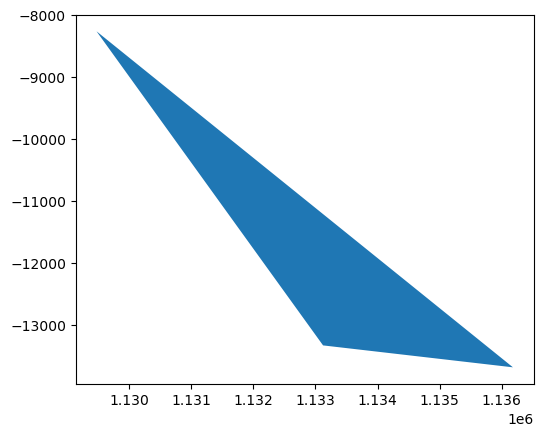

In [106]:
# see them
systems.convex_hull.plot()

In [107]:
systems_hulls=systems.convex_hull.to_frame()
systems_hulls['system']=['Amazon', 'Amazon']
systems_hulls.rename(columns={0:'geometry'},inplace=True)
systems_hulls=systems_hulls.set_geometry('geometry')
systems_hulls.crs="EPSG:24817"
systems_hulls

ValueError: Length of values (2) does not match length of index (1)

In [108]:
distanceMatrixKM_sysHull_air=systems_hulls.set_index('system').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

distanceMatrixKM_sysHull_air

KeyError: "None of ['system'] are in the columns"

In [109]:
mins=distanceMatrixKM_sysHull_air.idxmin(axis="columns")
mins

NameError: name 'distanceMatrixKM_sysHull_air' is not defined

In [110]:
# plotting
base=systems_hulls.explore()
largeAirports[largeAirports.name.isin(mins)].explore(m=base,color='red',marker_kwds=dict(radius=10))
largeAirports[~largeAirports.name.isin(mins)].explore(m=base,color='blue',marker_kwds=dict(radius=5))

In [111]:
#EXERCISE 4

# remember:
distanceMatrixKM_riv_air

name,José Joaquín de Olmedo International Airport,Mariscal Sucre International Airport
NAME,,
Putamayo,554.927267,334.761258


In [113]:
# getting a value (it can be any value)
distanceMatrixKM_riv_air.loc['Putamayo'].min() # I chose min

334.7612584139475

In [114]:
minMts=distanceMatrixKM_riv_air.loc['Putamayo'].min()*1000 # km

#the buffer is a polygon:
rivers[rivers.NAME=='Putamayo'].buffer(distance = minMts)

0    POLYGON ((1342648.410 249342.563, 1352850.452 ...
dtype: geometry

In [115]:
# see buffer:
bufferAroundAmazon=rivers[rivers.NAME=='Putamayo'].buffer(distance = minMts)
bufferAsBase=bufferAroundAmazon.explore(color='red')
rivers[rivers.NAME=='Putamayo'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})

In [116]:
small_airports=airports[airports['kind']=='small_airport']

# plotting
rivers[rivers.NAME=='Putamayo'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})
small_airports.explore(m=bufferAsBase,color='black')

In [117]:

riversWithinBuffer=small_airports.clip(mask=bufferAroundAmazon)
#
riversWithinBuffer

,name,kind,latitude_deg,longitude_deg,elevation_ft,region_name,municipality,geometry
177,Mashuin Airstrip,small_airport,-2.616113,-76.916497,854.0,Morona-Santiago Province,Mashuin,POINT (954558.549 -289534.385)
114,Kuserua Airstrip,small_airport,-2.607173,-76.934738,855.0,Morona-Santiago Province,Huasaga,POINT (952528.930 -288537.129)
299,Wachirpas Airstrip,small_airport,-2.573494,-76.806843,850.0,Morona-Santiago Province,Wachirpas,POINT (966795.283 -284851.200)
42,Andoas Airstrip,small_airport,-2.568889,-76.660795,NaN,Pastaza Province,Andoas,POINT (983077.494 -284395.153)
121,Ishpingo de Amuntay Airstrip,small_airport,-2.566312,-76.756598,826.0,Morona-Santiago Province,Ishpingo de Amuntay,POINT (972398.560 -284073.678)
...,...,...,...,...,...,...,...,...
259,Shushufindi Airport,small_airport,-0.195626,-76.648237,844.0,Sucumbios Province,Shushufind,POINT (984958.490 -21318.021)
159,Guarumo Airport,small_airport,-0.050556,-76.568889,838.0,Sucumbios Province,Lago Agrio,POINT (993816.626 -5237.238)
30,Andes Aeroclub Airport,small_airport,0.061667,-78.222833,9760.0,Pichincha Province,None,POINT (809399.917 7190.191)
17,Nueva Loja Airport,small_airport,0.093056,-76.867500,980.0,Sucumbios Province,Lago Agrio,POINT (960494.366 10679.823)


In [118]:
# plotting the airports within buffer
bufferAsBase=bufferAroundAmazon.explore(color='red')
rivers[rivers.NAME=='Amazon'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})
riversWithinBuffer.explore(m=bufferAsBase,color='black')

IndexError: list index out of range

In [119]:
# minimum of all the minimum by row
distanceMatrixKM_riv_air.min(axis=1).min() 

334.7612584139475

In [120]:
# using the previous value
minMinMts_5=5*distanceMatrixKM_riv_air.min(axis=1).min()*1000


allMinBuffer=rivers.buffer(distance = minMinMts_5).explore(color='red')
rivers.explore(m=allMinBuffer,color='blue',style_kwds={'weight':0.5})

In [121]:
# you see all the buffer polygons:
riversAll_buf=rivers.buffer(distance = minMinMts_5)
riversAll_buf

0    POLYGON ((1939820.431 1454004.472, 1949790.886...
dtype: geometry

In [122]:
allRiversWithinBuffs=small_airports.clip(riversAll_buf)
allRiversWithinBuffs

,name,kind,latitude_deg,longitude_deg,elevation_ft,region_name,municipality,geometry
87,Cumbaratza Airport,small_airport,-4.018793,-78.887293,2871.0,Zamora-Chinchipe Province,Cumbaratza,POINT (734822.399 -444142.887)
26,Ciudad de Catamayo Airport,small_airport,-3.995606,-79.371902,4056.0,Loja Province,La Toma (Catamayo),POINT (681005.556 -441456.007)
162,Loja Airport,small_airport,-3.881424,-79.234749,7684.0,Loja Province,Loja,POINT (696263.744 -428860.224)
68,Carabon Airport,small_airport,-3.628550,-80.187798,126.0,El Oro Province,Carabon,POINT (590452.733 -400745.521)
248,Gualaquiza Airport,small_airport,-3.423210,-78.567001,2640.0,Morona-Santiago Province,Santiago,POINT (770585.105 -378349.678)
...,...,...,...,...,...,...,...,...
226,Putumayo Airport,small_airport,0.115949,-75.850220,733.0,Sucumbios Province,Puerto Putumayo,POINT (1074068.345 13236.445)
295,Km 192 Airport,small_airport,0.184650,-79.391181,1247.0,Esmeraldas Province,Vía Quinindé-La Concordia,POINT (679292.816 20782.446)
237,Tapatla Airstrip,small_airport,1.064419,-79.351037,18.0,Esmeraldas Province,Rocafuerte,POINT (683730.246 118064.568)
100,Palpailón,small_airport,1.221636,-78.868266,69.0,Esmeraldas Province,Esmeraldas,POINT (737457.931 135487.408)


<Axes: >

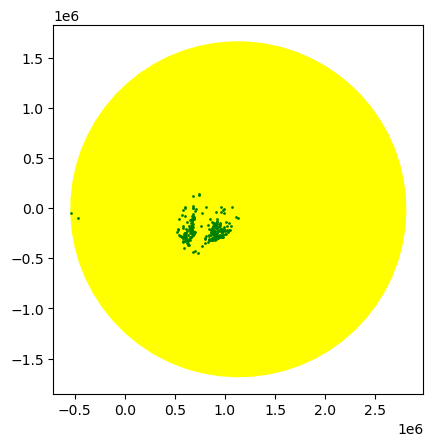

In [123]:
# simple
base=riversAll_buf.plot(color='yellow')
allRiversWithinBuffs.plot(ax=base, color='green', markersize=1)

In [124]:
# folium

base=riversAll_buf.explore(color='yellow')
allRiversWithinBuffs.explore(m=base, color='green')